In [1]:
import re
import nltk
import pickle
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

warnings.filterwarnings("ignore")

# EDA y modelado de datos.

In [2]:
data = pd.read_csv("./data/Projects_cleansed.csv")
data.head()

,Project Title,Project Short Description,Project Subject Category Tree,Project Cost,Project Current Status
0,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Applied Learning,361.80,Fully Funded
1,Learning in Color!,"Help us have a fun, interactive listening cent...","Applied Learning, Literacy & Language",512.85,Expired
2,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Literacy & Language,435.92,Fully Funded
3,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Literacy & Language,161.26,Fully Funded
4,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...",Special Needs,264.19,Fully Funded


In [3]:
data["Project Current Status"].value_counts()

Fully Funded    826740
Expired         241390
Live             41851
Name: Project Current Status, dtype: int64

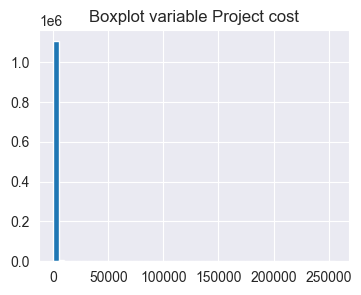

In [4]:
data["Project Cost"].hist(bins=50, figsize=(4, 3))
plt.title("Boxplot variable Project cost")
plt.show()

## Tratamiento variable `Project Cost`.

In [5]:
# Exploración variable de costo
print(f"El máximo de costo es de: {data['Project Cost'].max()}")
print(f"El mínimo de costo es de: {data['Project Cost'].min()}")
print(f"La media de costo es de: {data['Project Cost'].mean()}")
print(f"La mediana de costo es de: {data['Project Cost'].median()}")

El máximo de costo es de: 255737.67
El mínimo de costo es de: 35.29
La media de costo es de: 741.519443612098
La mediana de costo es de: 515.35


In [6]:
# Tenemos datos atípicos, vamos a ver que tanto
a = data[data["Project Cost"]<5000].shape
b = data[data["Project Cost"]>5000].shape
# El 5000 es un valor arbitrario, pero también gráficamente noté que sería un buen corte
print(f"Tamaño del dataset {a[0]}, tamaño del recorte {b[0]}")
# Eliminamos los datos mayores a 5000 en costo, pues representan menos del 1% y son muy atípicos.
print(f"Porcentaje de datos que nos quedan: {(a[0]*100)/len(data)}")
data = data[data["Project Cost"]<5000]

Tamaño del dataset 1104192, tamaño del recorte 5789
Porcentaje de datos que nos quedan: 99.47845954119936


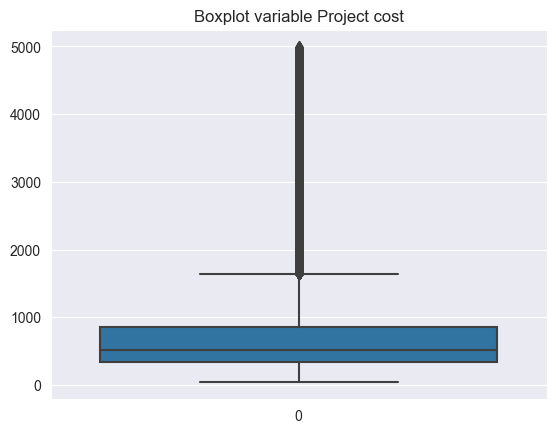

In [7]:
sns.boxplot(data["Project Cost"])
plt.title("Boxplot variable Project cost")
plt.show()

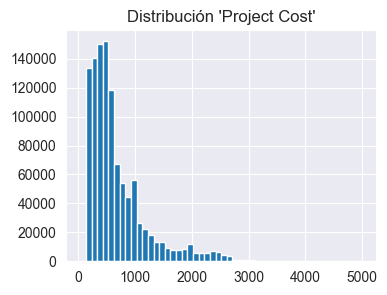

In [8]:
data["Project Cost"].hist(bins=50, figsize=(4, 3))
plt.title("Distribución 'Project Cost'")
plt.show()

## Tratamiento variable de respuesta.

En este caso solo les daremos valores de 0 para ver si no lo fondearon  y 1 para ver si si lo fondearon que nos servirán únicamente como etiquetas.

In [9]:
data["Project Current Status"].value_counts()

Fully Funded    823849
Expired         238950
Live             41393
Name: Project Current Status, dtype: int64

In [10]:
data["Project Current Status"].replace({"Fully Funded":1, "Live":1, "Expired":0}, inplace=True)
data.head()

,Project Title,Project Short Description,Project Subject Category Tree,Project Cost,Project Current Status
0,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,Applied Learning,361.80,1
1,Learning in Color!,"Help us have a fun, interactive listening cent...","Applied Learning, Literacy & Language",512.85,0
2,Help Second Grade ESL Students Develop Languag...,Visiting or moving to a new place can be very ...,Literacy & Language,435.92,1
3,Help Bilingual Students Strengthen Reading Com...,Students at our school are still working hard ...,Literacy & Language,161.26,1
4,Help Us Make Each Minute Count!,"""Idle hands"" were something that Issac Watts s...",Special Needs,264.19,1


## Tratamiento variable `Project Subject Category Tree`.

Utilizaremos el método de frecuencia para sustituir el texto. Ya que si hiciéramos one-hot encoding, tendríamos 50 variables nuevas y de esta forma podemos darle un peso a cada una de las opciones.

In [11]:
data["Project Subject Category Tree"].value_counts()

Literacy & Language                           249929
Math & Science                                171202
Literacy & Language, Math & Science           153322
Music & The Arts                               56408
Health & Sports                                48358
Applied Learning                               44723
Literacy & Language, Special Needs             41180
Special Needs                                  35481
Applied Learning, Literacy & Language          30984
Math & Science, Literacy & Language            27796
Literacy & Language, Music & The Arts          21102
Applied Learning, Special Needs                20407
History & Civics                               20327
Math & Science, Special Needs                  18577
History & Civics, Literacy & Language          18502
Math & Science, Music & The Arts               16817
Math & Science, Applied Learning               15207
Applied Learning, Math & Science               12837
Literacy & Language, History & Civics         

In [12]:
# Agrupando
group = data.groupby("Project Subject Category Tree").agg({"Project Current Status": ['mean', 'count']})
group = group["Project Current Status"]
# Agregamos la proporción
group['prop'] = group['count'] / group['count'].sum()
# Ordenemos el DataFrame por el tamaño de la proporción.
group = group.sort_values('prop', ascending=False)
group = group["prop"].reset_index()
group

,Project Subject Category Tree,prop
0,Literacy & Language,0.226346
1,Math & Science,0.155047
2,"Literacy & Language, Math & Science",0.138854
3,Music & The Arts,0.051085
4,Health & Sports,0.043795
5,Applied Learning,0.040503
6,"Literacy & Language, Special Needs",0.037294
7,Special Needs,0.032133
8,"Applied Learning, Literacy & Language",0.028060
9,"Math & Science, Literacy & Language",0.025173


In [13]:
data = data.merge(group, on="Project Subject Category Tree")
data.drop(columns="Project Subject Category Tree", inplace=True)
data.head()

,Project Title,Project Short Description,Project Cost,Project Current Status,prop
0,Stand Up to Bullying: Together We Can!,Did you know that 1-7 students in grades K-12 ...,361.80,1,0.040503
1,Experiencing India,Travel and hands on experiences outside the cl...,3020.59,1,0.040503
2,"It Is Time To Grab This ""Bully"" By The Horns!!","Teasing is part of being a kid, right? Wrong! ...",400.19,1,0.040503
3,You Can Read the Signs on the Wall,"In our fast paced world, students are being su...",528.49,1,0.040503
4,Props For Passionate Play,Students' play takes them to a higher social f...,396.92,1,0.040503


## Eliminación de la variable de título.

Como vamos a tratar la variable de ´Project Short Description´ vectorizando y generando varias columnas, la variable del título no nos va a servir de mucho.

In [14]:
data = data[["Project Short Description", "Project Cost", "prop", "Project Current Status"]].reset_index(drop=True)
data.head()

,Project Short Description,Project Cost,prop,Project Current Status
0,Did you know that 1-7 students in grades K-12 ...,361.80,0.040503,1
1,Travel and hands on experiences outside the cl...,3020.59,0.040503,1
2,"Teasing is part of being a kid, right? Wrong! ...",400.19,0.040503,1
3,"In our fast paced world, students are being su...",528.49,0.040503,1
4,Students' play takes them to a higher social f...,396.92,0.040503,1


## Tratamiento de la variable de `Project Short Description`.

In [15]:
data_textos = list(data["Project Short Description"])
clean_texts = []

for text in data_textos:
        text = text.lower() # Ponemos en minúsculas nuestros textos
        text = re.sub("\W", " ", text) # Eliminamos caracteres especiales
        text = re.sub("\d", "", text) # Eliminamos números
        text = re.sub("\s+", " ", text) # Eliminamos más de 1 espacio
        text = re.sub("\.+", "", text) # Eliminamos los puntos del final
        text = re.sub('\_', '', text)# Quitando '_'
        clean_texts.append(text)

In [16]:
# Ejemplo de como queda el texto después de la limpieza.
print("Texto limpio:")
print(clean_texts[0])
print()
print("Texto Original:")
print(data["Project Short Description"][0])

Texto limpio:
did you know that students in grades k is either a bully or a victim of bullying my goal is to raise prevention through being educated and aware of the effects and consequences of 

Texto Original:
Did you know that 1-7 students in grades K-12 is either a bully or a victim of bullying? My goal is to raise prevention through being educated and aware of the effects and consequences of...


Primero vectorizamos nuestras descripciones con ayuda de sklearn con un modelo Count Vectorizer, posteriormente aplicaremos un modelo TF-IDF


In [17]:
# Importamos stopwords de la librería nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pvilla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [18]:
vectorizer = CountVectorizer(max_features=500, # Máximas características
                             min_df=5, # Si una palabra sale en menos de 3 archivos no la pongas (Poco común)
                             max_df=0.6, # Si una palabra salen en más del 60% de los archivos no la pongas (Muy común)
                             stop_words=stopwords.words('english')) # Quitando los stopwords

In [19]:
# Creamos el bag of words
bow = vectorizer.fit_transform(clean_texts).toarray()

In [20]:
# Creando el Objeto para TF-IDF
transformer = TfidfTransformer().fit(bow)

# Ejecutando la transformación
tfidf = transformer.fit_transform(bow).toarray()

In [21]:
# Lo pasamos a dataframe para concatenar las otras variables
tfidf = pd.DataFrame(tfidf)
# Hacemos merge con los datos de la tabla original
data_modeling = tfidf.merge(data, right_index=True, left_index=True)
# Eliminamos los textos
data_modeling.drop(columns=["Project Short Description"], inplace=True)
data_modeling.head()

,0,1,2,3,4,5,6,7,8,9,...,493,494,495,496,497,498,499,Project Cost,prop,Project Current Status
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,361.80,0.040503,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3020.59,0.040503,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,400.19,0.040503,1
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,528.49,0.040503,1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,396.92,0.040503,1


In [22]:
# Dividiendo en train y test
X_train, X_test, y_train, y_test = train_test_split(data_modeling.drop(columns=["Project Current Status"]),
                                                    data_modeling["Project Current Status"],
                                                    test_size=0.2, random_state=27)


# Entrenamos un modelo de Regresión Logística
model = LogisticRegression()
model.fit(X_train, y_train)

# Probando el Modelo
y_pred = model.predict(X_test)

In [23]:
# Evaluamos el modelo con el accuracy y con una matriz de confusión
print(f"Accuracy: {model.score(X_test, y_test)}")

matrix = confusion_matrix(y_test, y_pred)
print()
print("Confusion Matrix")
print(pd.DataFrame(matrix))

print()
print(f"Sensitivity (Recall): {recall_score(y_test, y_pred)}")

Accuracy: 0.7818863515955062

Confusion Matrix
      0       1
0  3334   44257
1  3911  169337

Sensitivity (Recall): 0.977425424824529


Es un buen accuracy, pero en la confusion matrix podemos ver que si afecta que no esté balanceada la variable de respuesta, ya que predice muy bien los 1, pero los 0 no tanto.

Lo bueno es que en la vision de la base de datos nos interesa si se va a fondear el proyecto (recall), entonces nos arriesgamos con este modelo.

## Exportamos nuestro modelo, nuestros transformers y datos que nos sirven para la API


In [24]:
# Guardando el modelo
with open('model_class.pickle', 'wb') as f:
    pickle.dump(model, f)

# Guardando el vectorizador y el modelo TF-IDF
with open('model_tf_idf.pickle', 'wb') as f:
    pickle.dump(transformer, f)

with open('vectorizer.pickle', 'wb') as f:
    pickle.dump(vectorizer, f)

# Guardamos el transformador del subject
group.to_excel("Transform_subject.xlsx", index=False)